# embedding analytics

some functions to assess the usefulness of embeddings

compare one segment to other segments in its own track and `n` other tracks

## imports

In [1]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from diffusers.pipelines.deprecated.spectrogram_diffusion.notes_encoder import (
    SpectrogramNotesEncoder,
)
from diffusers import MidiProcessor
from midi_player import MIDIPlayer
from midi_player.stylers import dark

plt.style.use("dark_background")

torch.set_grad_enabled(False)

ModuleNotFoundError: No module named 'transformers'

## parameters

In [2]:
VALID_EXTENSIONS = (".mid", ".midi")
WEIGHT_PRS = True
input_path = "/media/nova/Datasets/sageev-midi/20250110/segmented/"
# test_file = "/media/nova/Datasets/sageev-midi/20250110/segmented/20240511-088-03/20240511-088-03_0169-0174.mid"
test_file = None
n_tracks = 3
device = "cuda:1"
batch_size = 4

encoder_config = {
    "d_ff": 2048,
    "d_kv": 64,
    "d_model": 768,
    "dropout_rate": 0.1,
    "feed_forward_proj": "gated-gelu_pytorch_tanh",
    "is_decoder": False,
    "max_length": 2048,
    "num_heads": 12,
    "num_layers": 12,
    "vocab_size": 1536,
}
encoder_weights = "../data/note_encoder.bin"

## load tokenizer and encoder

In [ ]:
processor = MidiProcessor()
encoder = SpectrogramNotesEncoder(**encoder_config).cuda(device=device)
encoder.eval()
sd = torch.load(encoder_weights, weights_only=True)
encoder.load_state_dict(sd)

<All keys matched successfully>

## generate embeddings

### select tracks

In [4]:
selected_tracks = []
if test_file is None:
    selected_tracks = random.sample(
        [
            os.path.join(input_path, track_folder)
            for track_folder in os.listdir(input_path)
        ],
        n_tracks,
    )
else:
    test_track = os.path.basename(os.path.dirname(test_file))
    selected_tracks = [os.path.join(input_path, test_track)]
    selected_tracks += random.sample(
        [
            os.path.join(input_path, track_folder)
            for track_folder in os.listdir(input_path)
            if track_folder != test_track
        ],
        n_tracks - 1,
    )

print(f"selected tracks are: {selected_tracks}")
print(f"key file is: {test_file}")

selected tracks are: ['/media/nova/Datasets/sageev-midi/20250110/segmented/20240122-055-01', '/media/nova/Datasets/sageev-midi/20250110/segmented/20240312-080-02', '/media/nova/Datasets/sageev-midi/20250110/segmented/20240117-064-06', '/media/nova/Datasets/sageev-midi/20250110/segmented/20240305-050-01', '/media/nova/Datasets/sageev-midi/20250110/segmented/20240402-064-04', '/media/nova/Datasets/sageev-midi/20250110/segmented/20240305-050-03', '/media/nova/Datasets/sageev-midi/20250110/segmented/20240121-070-09', '/media/nova/Datasets/sageev-midi/20250110/segmented/20240502-064-05', '/media/nova/Datasets/sageev-midi/20250110/segmented/20231227-080-04', '/media/nova/Datasets/sageev-midi/20250110/segmented/20240213-100-02']
key file is: None


### tokens

In [ ]:
midi_tokens = dict()

for midi_path in [
    os.path.join(input_path, track, file)
    for track in selected_tracks
    for file in os.listdir(track)
    if file.endswith(VALID_EXTENSIONS)
]:
    midi_tokens[midi_path] = processor(midi_path)  # [1, NUM_TOKENS]

keys = list(midi_tokens.keys())
all_tokens = torch.cat(
    [torch.IntTensor(midi_tokens[key][0]).view(1, -1) for key in keys]
)  # [NUM_FILES, NUM_TOKENS]

print(f"tokenized {len(midi_tokens.keys())} files")

tokenized 561 files


### embeddings

In [6]:
midi_embeddings = dict()
for i in range(0, all_tokens.shape[0], batch_size):
    batch = all_tokens[i : i + batch_size].cuda(
        device=device
    )  # [BATCH_SIZE, NUM_TOKENS]

    with torch.autocast("cuda"):
        tokens_mask = batch > 0  # [varies]
        tokens_embedded, tokens_mask = encoder(
            encoder_input_tokens=batch, encoder_inputs_mask=tokens_mask
        )

    for idx in range(batch.shape[0]):
        avg_embedding = tokens_embedded[idx][tokens_mask[idx]].mean(0)  # [LATENT_DIM]
        midi_embeddings[keys[i + idx]] = avg_embedding

## calculate similarities

In [ ]:
if test_file is None:
    test_file = random.sample(keys, 1)[0]
    print(f"randomly selected test file {test_file}")

# cosine similarity
similarity_metric = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

test_embedding = midi_embeddings[test_file]
similarities = dict()
for file, embedding in midi_embeddings.items():
    track = os.path.basename(os.path.dirname(file))
    similarities[file] = (
        track,
        similarity_metric(test_embedding.cpu().detach(), embedding.cpu().detach()),
    )

sorted_sims = sorted(similarities.items(), key=lambda x: x[1][1], reverse=True)
print(f"{'Index':<10}{'Similarity':<15}{'Filename'}")
print("-" * 80)
for idx, (filename, (track, similarity)) in enumerate(sorted_sims):
    print(f"{idx:<10}{similarity:<15.4f}{filename}")

randomly selected test file /media/nova/Datasets/sageev-midi/20250110/segmented/20240213-100-02/20240213-100-02_0878-0883.mid
Index     Similarity     Filename
--------------------------------------------------------------------------------
0         1.0000         /media/nova/Datasets/sageev-midi/20250110/segmented/20240213-100-02/20240213-100-02_0878-0883.mid
1         0.9914         /media/nova/Datasets/sageev-midi/20250110/segmented/20240213-100-02/20240213-100-02_0859-0863.mid
2         0.9881         /media/nova/Datasets/sageev-midi/20250110/segmented/20240213-100-02/20240213-100-02_0863-0868.mid
3         0.9861         /media/nova/Datasets/sageev-midi/20250110/segmented/20240213-100-02/20240213-100-02_0868-0873.mid
4         0.9808         /media/nova/Datasets/sageev-midi/20250110/segmented/20240213-100-02/20240213-100-02_0883-0887.mid
5         0.9721         /media/nova/Datasets/sageev-midi/20250110/segmented/20240213-100-02/20240213-100-02_0820-0825.mid
6         0.9698     

## similarity bar chart

visualize the similarity of the chosen segment against the entire track

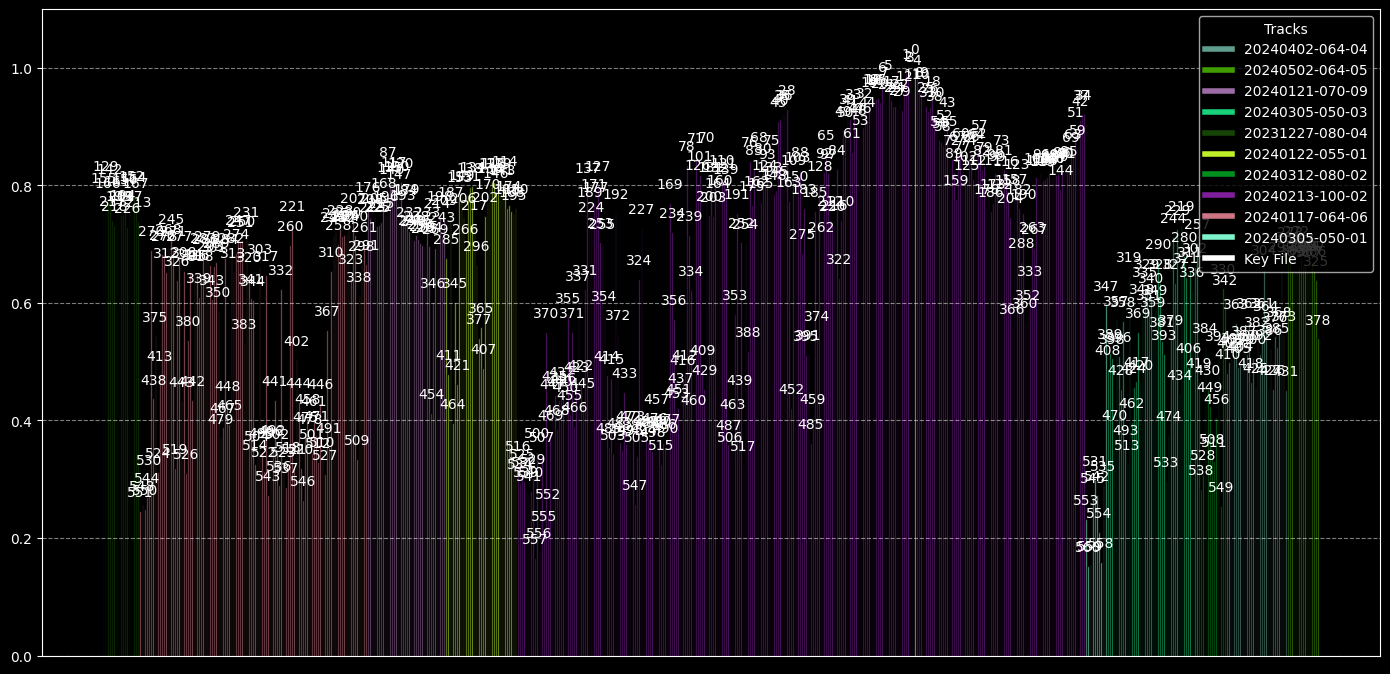

In [ ]:
# sort dictionary by key (filename) alphabetically
time_sorted_items = sorted(similarities.items(), key=lambda x: x[0])
filenames = [item[0] for item in time_sorted_items]
tracks = [item[1][0] for item in time_sorted_items]
just_similarities = [item[1][1] for item in time_sorted_items]

# assign unique colors to each track (excluding the key_file bar)
track_colors = {
    track: random.choice(list(mcolors.XKCD_COLORS.values()))
    for track in list(set(tracks))
}

# initialize the bar colors, setting the key_file bar to white
bar_colors = [
    "white" if filename == test_file else track_colors[track]
    for filename, track in zip(filenames, tracks)
]

# create bar chart
plt.figure(figsize=(14, 7))
bars = plt.bar(
    np.arange(len(just_similarities)),
    just_similarities,
    color=bar_colors,
    edgecolor="black",
    alpha=0.8,
)

# add labels above each bar
sim_indices = {item[0]: idx for idx, item in enumerate(sorted_sims)}
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.02,  # slightly above the bar
        f"{sim_indices[filenames[i]]}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# legend
legend_elements = [
    plt.Line2D([0], [0], color=color, lw=4, label=track)
    for track, color in track_colors.items()
]
legend_elements.append(plt.Line2D([0], [0], color="white", lw=4, label="Key File"))
plt.legend(handles=legend_elements, title="Tracks", loc="upper right")

plt.ylim(0, 1.1)  # ensure theres room for key file index label
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.xticks([])
plt.show()

## file playback

**enter the index of the file you want to listen to**:

In [9]:
file_index = 1

In [ ]:
chosen_file = sorted_sims[file_index][0]
MIDIPlayer(chosen_file, 300, styler=dark, title=os.path.basename(chosen_file))

### key segment

In [ ]:
MIDIPlayer(test_file, 300, styler=dark, title=os.path.basename(test_file))

### standard matches

In [12]:
key_track = similarities[test_file][0]
best_same, worst_same = None, None
best_diff, worst_diff = None, None

for i, (file, (track, similarity)) in enumerate(sorted_sims):
    if file == test_file:
        continue

    if track == key_track:
        if best_same is None or similarity > best_same[2]:
            best_same = (file, track, similarity, i)
        if worst_same is None or similarity < worst_same[2]:
            worst_same = (file, track, similarity, i)
    else:
        if best_diff is None or similarity > best_diff[2]:
            best_diff = (file, track, similarity, i)
        if worst_diff is None or similarity < worst_diff[2]:
            worst_diff = (file, track, similarity, i)

#### best match same track

In [ ]:
title = f"{os.path.basename(test_file)} has similarity {best_same[2]:.03f} to {os.path.basename(best_same[0])} (index {best_same[3]})"
MIDIPlayer(best_same[0], 300, styler=dark, title=title)

#### worst match same track

In [14]:
title = f"{os.path.basename(test_file)} has similarity {worst_same[2]:.03f} to {os.path.basename(worst_same[0])} (index {worst_same[3]})"
MIDIPlayer(worst_same[0], 300, styler=dark, title=title)

#### best match different track

In [ ]:
title = f"{os.path.basename(test_file)} has similarity {best_diff[2]:.03f} to {os.path.basename(best_diff[0])} (index {best_diff[3]})"
MIDIPlayer(best_diff[0], 300, styler=dark, title=title)

#### worst match different track

In [ ]:
title = f"{os.path.basename(test_file)} has similarity {worst_diff[2]:.03f} to {os.path.basename(worst_diff[0])} (index {worst_diff[3]})"
MIDIPlayer(worst_diff[0], 300, styler=dark, title=title)